In [1]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
import keras.layers as L
from keras import optimizers, losses, metrics, Model
from keras.callbacks import EarlyStopping
from keras.models import load_model
import shutil
import datetime
import os
from tensorflow.keras.models import load_model
import pickle

random.seed()

2024-02-24 09:54:27.339284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 09:54:27.339334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 09:54:27.382461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 09:54:27.469527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 09:54:28.258298: W tensorflow/compiler/tf2

# Seperate The Train immages into Folders

In [ ]:
def copy_images_to_class_directories(directory, csv_file):
    # Read CSV file
    df = pd.read_csv(csv_file)
    label_dict = dict(zip(df['Image'], df['Label']))

    # Create directories for each class (0 and 1) in the Separated directory
    separated_directory = os.path.join(os.path.dirname(directory), 'Separated')
    for class_label in ['0', '1']:
        os.makedirs(os.path.join(separated_directory, class_label), exist_ok=True)

    # Iterate through images and copy them to respective directories
    for file in os.listdir(directory):
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(directory, file)
            image_id = int(file.split('.')[0])  # Extract image ID from the file name
            label = label_dict.get(image_id, 'Unknown')
            label = '1' if label == "Mitosis" else '0'
            destination_directory = os.path.join(separated_directory, label)
            shutil.copy(image_path, destination_directory)

directory = 'softec-aic-2024/Training Images'
csv_file = 'softec-aic-2024/Train.csv'
copy_images_to_class_directories(directory, csv_file)

# Use a pretrained efficent net b0 as a faature extractor

In [8]:
# Define the EfficientNetB0 model with average pooling layer
feature_extractor = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
max_pooling_layer = MaxPooling2D(pool_size=(7, 7))  # Assuming the feature map size is 7x7
feature_extractor = tf.keras.Sequential([
    feature_extractor,
    max_pooling_layer
])

# 224, 224, 3
feature_extractor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 1280)        0         
 g2D)                                                            
                                                                 
Total params: 4049571 (15.45 MB)
Trainable params: 4007548 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


# Augment the seperated Immages

In [9]:
# Function to flip images horizontally and vertically
def flip_images(image):
    flipped_horizontally = cv2.flip(image, 1)
    flipped_vertically = cv2.flip(image, 0)
    return flipped_horizontally, flipped_vertically

# Function to perform image augmentation with flipping
def augment_image(input_directory, output_directory, class_label, filename):
    input_class_directory = os.path.join(input_directory, class_label)
    output_class_directory = os.path.join(output_directory, class_label)
    os.makedirs(output_class_directory, exist_ok=True)
    
    image_path = os.path.join(input_class_directory, filename)
    image = cv2.imread(image_path)
    
    if image is not None:
        # Flip horizontally and vertically
        flipped_horizontally, flipped_vertically = flip_images(image)
        
        # Save flipped images
        output_filename_horizontal = os.path.splitext(filename)[0] + '_flipped_horizontal.jpg'
        output_filename_vertical = os.path.splitext(filename)[0] + '_flipped_vertical.jpg'
        output_path_horizontal = os.path.join(output_class_directory, output_filename_horizontal)
        output_path_vertical = os.path.join(output_class_directory, output_filename_vertical)
        cv2.imwrite(output_path_horizontal, flipped_horizontally)
        cv2.imwrite(output_path_vertical, flipped_vertically)
        
        print(f"Flipped images saved for {filename}")
    else:
        print(f"Unable to read image: {image_path}")

# Function to perform image augmentation for each class
def parallel_augmentation(input_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    for class_label in ['0', '1']:
        input_class_directory = os.path.join(input_directory, class_label)
        output_class_directory = os.path.join(output_directory, class_label)
        filenames = os.listdir(input_class_directory)
        for filename in filenames:
            augment_image(input_directory, output_directory, class_label, filename)

# Example usage
input_directory = 'softec-aic-2024/Separated'
output_directory = 'softec-aic-2024/Augmented'
parallel_augmentation(input_directory, output_directory)


Flipped images saved for 93.jpg
Flipped images saved for 2.jpg
Flipped images saved for 13.jpg
Flipped images saved for 8.jpg
Flipped images saved for 160.jpg
Flipped images saved for 221.jpg
Flipped images saved for 215.jpg
Flipped images saved for 152.jpg
Flipped images saved for 198.jpg
Flipped images saved for 131.jpg
Flipped images saved for 5.jpg
Flipped images saved for 178.jpg
Flipped images saved for 177.jpg
Flipped images saved for 163.jpg
Flipped images saved for 208.jpg
Flipped images saved for 126.jpg
Flipped images saved for 41.jpg
Flipped images saved for 153.jpg
Flipped images saved for 128.jpg
Flipped images saved for 143.jpg
Flipped images saved for 137.jpg
Flipped images saved for 149.jpg
Flipped images saved for 188.jpg
Flipped images saved for 190.jpg
Flipped images saved for 94.jpg
Flipped images saved for 168.jpg
Flipped images saved for 200.jpg
Flipped images saved for 34.jpg
Flipped images saved for 182.jpg
Flipped images saved for 38.jpg
Flipped images saved f

# Use a sliding window approach to get the features per window
# Concatonate these features across every window to get a singular feature vector

In [10]:
def sliding_window(image, window_size, overlap):
    height, width, _ = image.shape
    window_height, window_width, _ = window_size
    stride_x = int(window_width * (1 - overlap))
    stride_y = int(window_height * (1 - overlap))
    
    windows = []
    positions = []
    
    for y in range(0, height - window_height + 1, stride_y):
        for x in range(0, width - window_width + 1, stride_x):
            window = image[y:y+window_height, x:x+window_width, :]
            windows.append(window)
            positions.append((x, y))
    
    return windows, positions

# Define window size and overlap
window_size = (224, 224, 3)
overlap = 0.2

In [12]:
# Define the batch size
batch_size = 500  # Adjust the batch size as needed

filesArray = []
for path, subdirs, files in os.walk("softec-aic-2024/Augmented/1"):
    for name in files:
        filesArray.append(os.path.join(path, name))
random.shuffle(filesArray)

# Define the base directory where features will be saved
base_directory = "softec-aic-2024/Training Features/1"

# Get list of files already present in the output directory
existing_files = os.listdir(base_directory)

# Extract only the basenames without extension from existing files
existing_filenames = set(os.path.splitext(os.path.basename(filename))[0] for filename in existing_files)

# Filter filesArray to exclude filenames that are already present in the output directory
filesArray_filtered = [file_path for file_path in filesArray if os.path.splitext(os.path.basename(file_path))[0] not in existing_filenames]

print(f'{len(filesArray)} - {len(existing_files)} = {len(filesArray_filtered)}')

# Iterate through image paths
for image_path in filesArray_filtered:
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Apply sliding window
    windows, positions = sliding_window(image, window_size, overlap)

    # Initialize list to accumulate features for all windows of the file
    all_features = []

    # Process windows in batches
    for i in range(0, len(windows), batch_size):
        batch_windows = windows[i:i+batch_size]

        # Preprocess batch of windows
        batch_preprocessed = [window for window in batch_windows]  # Preprocess windows as needed

        # Convert batch of windows to array
        batch_array = np.array(batch_preprocessed)

        # Predict features for the batch
        batch_features = feature_extractor.predict(batch_array)

        # Accumulate features for the batch
        all_features.append(batch_features)

    # Concatenate features for all batches
    all_features_concatenated = np.concatenate(all_features, axis=0)

    # Reshape features into one large feature vector
    all_features_concatenated = np.reshape(all_features_concatenated, (1, 1, -1))

    # Create the directory if it does not exist
    directory = base_directory
    os.makedirs(directory, exist_ok=True)

    # Extract the file name
    file_name = os.path.basename(image_path)

    # Pickle concatenated features and labels for all windows of the file
    with open(os.path.join(directory, f"{file_name}.pkl"), "wb") as f:
        pickle.dump(all_features_concatenated, f)

    print(f"Processed windows for {image_path}")


267 - 0 = 267
11/11 [==============================] - 0s 38ms/step
Processed windows for softec-aic-2024/Augmented/1/67.jpg
11/11 [==============================] - 0s 34ms/step
Processed windows for softec-aic-2024/Augmented/1/112_flipped_horizontal.jpg
11/11 [==============================] - 0s 35ms/step
Processed windows for softec-aic-2024/Augmented/1/217.jpg
11/11 [==============================] - 0s 34ms/step
Processed windows for softec-aic-2024/Augmented/1/91_flipped_horizontal.jpg
11/11 [==============================] - 0s 35ms/step
Processed windows for softec-aic-2024/Augmented/1/197_flipped_vertical.jpg
11/11 [==============================] - 0s 35ms/step
Processed windows for softec-aic-2024/Augmented/1/121_flipped_horizontal.jpg
11/11 [==============================] - 0s 34ms/step
Processed windows for softec-aic-2024/Augmented/1/32_flipped_vertical.jpg
11/11 [==============================] - 0s 35ms/step
Processed windows for softec-aic-2024/Augmented/1/217_flippe

In [35]:
# Directory containing pickle files
directory = "softec-aic-2024/Training Features/0"

# Get list of pickle files in the directory
pickle_files = [file for file in os.listdir(directory) if file.endswith('.pkl')]

# Randomly select a pickle file
random_pickle_file = random.choice(pickle_files)

# Load the pickle file
with open(os.path.join(directory, random_pickle_file), 'rb') as f:
    features = pickle.load(f)

# Check the size of the loaded features
print(f"Loaded features from {random_pickle_file}:")
print(f"Features shape: {features.shape}")
print(f"Number of windows: {features.shape[0]}")
print(f"Size of each window's features: {features.shape[1:]}")
print(f"Total number of features: {features.size}")
print(f"File size: {os.path.getsize(os.path.join(directory, random_pickle_file))} bytes")


Loaded features from 69_flipped_horizontal.jpg.pkl:
Features shape: (1, 1, 450560)
Number of windows: 1
Size of each window's features: (1, 450560)
Total number of features: 450560
File size: 1802406 bytes


# Train Simple Dense Layer Classifyer on the extracted Features

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 450560)            0         
                                                                 
 dropout_5 (Dropout)         (None, 450560)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               57671808  
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 57671937 (220.00 MB)
Trainable params: 57671937 (220.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
542/542 [==============================] - 19s 31ms/step - loss: 1005.8715 - binary_accuracy: 0.6365 - precision_5: 0.5253 - recall_

INFO:tensorflow:Assets written to: trained_model/assets


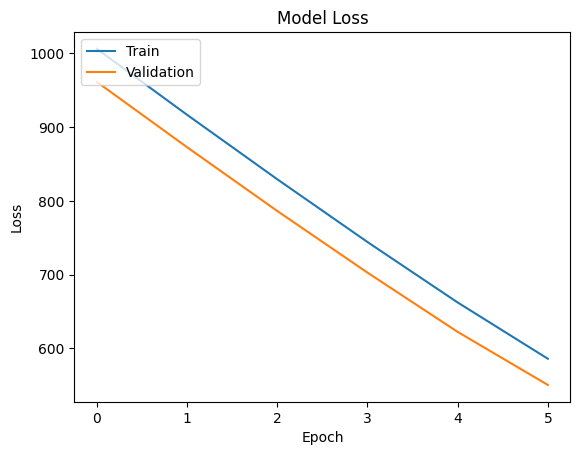

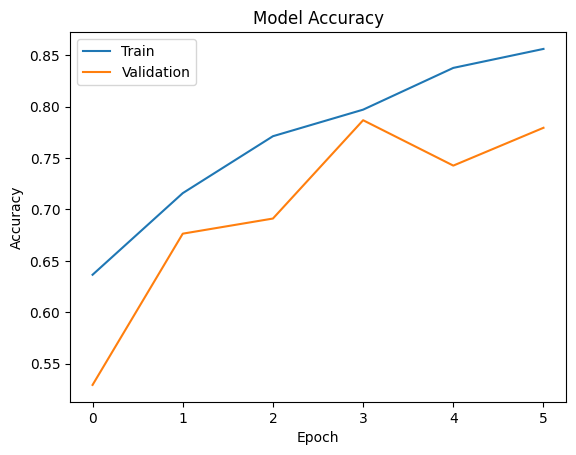

136/136 [==============================] - 1s 3ms/step


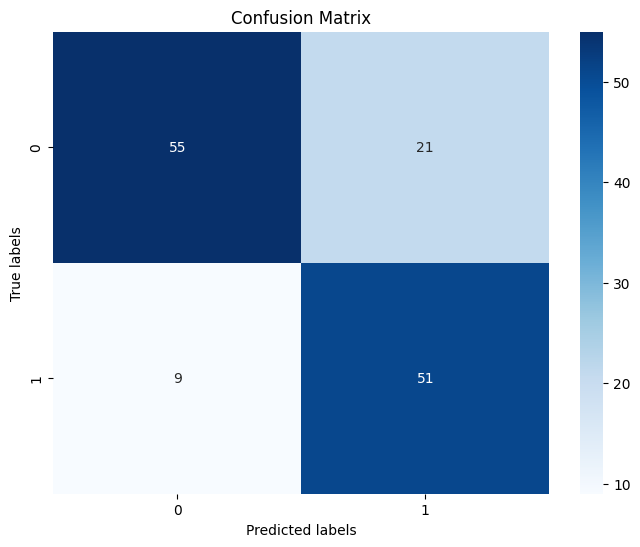

In [14]:

# Global variables
BATCH_SIZE = 1
LEARNING_RATE = 0.000001
NEURONS = 128
OPTIMIZER = 'Adam'

# Set random seed for reproducibility
random.seed()
from tensorflow.keras import regularizers

# Define the CNN architecture with L1 and L2 regularization
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 1, 450560)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.2, l2=0.03),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0.1, l2=0.01))
])

model.summary()

# Define a custom learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch >= 5:
        print("Learning rate:", lr)
        return lr * tf.math.exp(-0.06)
    else:
        return lr

# Define additional metrics
additional_metrics = [
    tf.metrics.Precision(),
    tf.metrics.Recall(),
    tf.metrics.AUC(),
]

# Compile the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.losses.BinaryFocalCrossentropy(alpha=0.3938, gamma=0.5),
              metrics=[tf.metrics.BinaryAccuracy(), additional_metrics])

# Load file paths
filesArray = []
for path, subdirs, files in os.walk("softec-aic-2024/Training Features"):
    for name in files:
        filesArray.append(os.path.join(path, name))

# Shuffle the list of file paths
random.shuffle(filesArray)

# Calculate the total number of samples
num_samples = len(filesArray)

# Define the size of the test set
test_size = 1+int(0.2 * num_samples)  # 25% of the data for testing

# Convert features and labels to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(filesArray[test_size:])
test_dataset = tf.data.Dataset.from_tensor_slices(filesArray[:test_size])

# Asynchronously load features and labels
def load_features_and_labels_async(file_path_tensor):
    # Convert the file path tensor to a string
    file_path = file_path_tensor.numpy().decode('utf-8')
    # Extract label
    label = int(os.path.basename(os.path.dirname(file_path)))
    # Open the pickle file in binary mode for reading
    with open(file_path, 'rb') as f:
        unpickled_object = pickle.load(f)
    return unpickled_object, label

train_dataset = train_dataset.map(lambda x: tf.py_function(load_features_and_labels_async, [x], (tf.float32, tf.int32)))
test_dataset = test_dataset.map(lambda x: tf.py_function(load_features_and_labels_async, [x], (tf.float32, tf.int32)))

# Shuffle, batch, and prefetch datasets
train_dataset = train_dataset.shuffle(buffer_size=300).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


# Define custom callback for TensorBoard with custom log file name
class CustomTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.log_dir = self._get_logs_dir(self.log_dir)

    def _get_logs_dir(self, logs_dir):
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_name = f"batch_size_{BATCH_SIZE}_lr_{LEARNING_RATE}_neurons_{NEURONS}_optimizer_{OPTIMIZER}_{current_time}"
        return os.path.join(logs_dir, log_name)

# Define TensorBoard callback with custom log file name
log_dir = './logs'  # Directory to store TensorBoard logs
tensorboard_callback = CustomTensorBoard(log_dir=log_dir)

# Implement Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with TensorBoard callback and Early Stopping
history = model.fit(train_dataset, 
                    epochs=6, 
                    validation_data=test_dataset, 
                    verbose=1,
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), tensorboard_callback, early_stopping_callback])

# Save the trained model
model.save('trained_model')

# Plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy vs epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculate predictions and create confusion matrix
predictions = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.round(predictions).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Train a Random Forest Classifyer on the Dataset

In [13]:
# Train random forests
# Load file paths
filesArray = []
for path, subdirs, files in os.walk("softec-aic-2024/Training Features"):
    for name in files:
        filesArray.append(os.path.join(path, name))

# Shuffle the list of file paths
random.shuffle(filesArray)

# Calculate the total number of samples
num_samples = len(filesArray)

# Define the size of the test set
test_size = 0.2  # 20% of the data for testing

# Split data into train and test sets
train_files, test_files = train_test_split(filesArray, test_size=test_size, random_state=42)

# Function to load features and labels
def load_features_and_labels(file_list):
    features = []
    labels = []
    for file in file_list:
        with open(file, 'rb') as f:
            feature = pickle.load(f)
            label = int(os.path.basename(os.path.dirname(file)))
            features.append(feature)
            labels.append(label)
    return np.array(features), np.array(labels)

# Load training features and labels
X_train, y_train = load_features_and_labels(train_files)

# Load testing features and labels
X_test, y_test = load_features_and_labels(test_files)

# Define Random Forest Classifier with 1000 trees and no bootstrapping
random_forest_classifier = RandomForestClassifier(n_estimators=900, bootstrap=False, n_jobs=-1)

# Train the Random Forest Classifier
random_forest_classifier.fit(X_train.reshape(len(X_train), -1), y_train)

# Make predictions on the test set using Random Forest Classifier
y_pred_random_forest = random_forest_classifier.predict(X_test.reshape(len(X_test), -1))

# Evaluate the Random Forest Classifier
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
class_report_random_forest = classification_report(y_test, y_pred_random_forest)

# Print results for Random Forest Classifier
print("Random Forest Classifier Accuracy:", accuracy_random_forest)
print("Random Forest Classifier Classification Report:")
print(class_report_random_forest)

# Save the trained Random Forest Classifier model as a .pkl file
model_filename = 'random_forest_classifier.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(random_forest_classifier, f)

print("Model saved as", model_filename)


Random Forest Classifier Accuracy: 0.8676470588235294
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        83
           1       0.83      0.83      0.83        53

    accuracy                           0.87       136
   macro avg       0.86      0.86      0.86       136
weighted avg       0.87      0.87      0.87       136

Model saved as random_forest_classifier.pkl


# Intermediate Code for generating predictions

In [ ]:
#Predict using TF

# Load the trained model
model = load_model('trained_model')

# Define the directory containing the testing features
testing_features_dir = "softec-aic-2024/Testing Features"

# Load file paths for testing features
testing_files = [os.path.join(testing_features_dir, file) for file in os.listdir(testing_features_dir)]

# Load features from testing data and extract image numbers
testing_features = []
image_numbers = []
for file_path in testing_files:
    image_number = os.path.splitext(os.path.basename(file_path))[0]  # Extract image number from file name
    image_numbers.append(image_number)
    with open(file_path, 'rb') as f:
        feature = pickle.load(f)
        testing_features.append(feature)

# Convert testing features to numpy array
testing_features = np.array(testing_features)

# Predict labels for testing features
predictions = model.predict(testing_features)

# Convert predictions to binary labels (0 for "Normal", 1 for "Mitosis")
binary_predictions = np.round(predictions).astype(int)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Image': image_numbers,
    'Label': ['Mitosis' if label == 1 else 'Normal' for label in binary_predictions]
})

# Write the results to Test.csv
results_df.to_csv('softec-aic-2024/Test.csv', index=False)


In [ ]:
#Predict using random Forest
# Load the saved Random Forest classifier
with open('random_forest_classifier.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

# Define the directory containing the testing features
testing_features_dir = "softec-aic-2024/Testing Features"

# Load file paths for testing features
testing_files = [os.path.join(testing_features_dir, file) for file in os.listdir(testing_features_dir)]

# Load features from testing data and extract image numbers
testing_features = []
image_numbers = []
for file_path in testing_files:
    image_number = os.path.splitext(os.path.basename(file_path))[0]  # Extract image number from file name
    image_numbers.append(image_number)
    with open(file_path, 'rb') as f:
        feature = pickle.load(f)
        testing_features.append(feature)

# Convert testing features to numpy array
testing_features = np.array(testing_features)

# Make predictions using the loaded Random Forest classifier
predictions = rf_classifier.predict(testing_features.reshape(len(testing_features), -1))

# Convert predictions to labels ("Mitosis" or "Normal")
predicted_labels = ["Mitosis" if label == 1 else "Normal" for label in predictions]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Image': image_numbers,
    'Label': predicted_labels
})

# Write the results to a CSV file
results_df.to_csv('softec-aic-2024/Test.csv', index=False)


# Use both classifyers to generate a combined prediction for the Testing Dataset

In [15]:
# Predict using both
# Load the saved Random Forest classifier
with open('random_forest_classifier.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

# Load the trained neural network model
model = load_model('trained_model')

# Define the directory containing the testing features
testing_features_dir = "softec-aic-2024/Testing Features"

# Load file paths for testing features
testing_files = [os.path.join(testing_features_dir, file) for file in os.listdir(testing_features_dir)]

# Load features from testing data and extract image numbers
testing_features = []
image_numbers = []
for file_path in testing_files:
    image_number = os.path.splitext(os.path.basename(file_path))[0]  # Extract image number from file name
    image_numbers.append(image_number)
    with open(file_path, 'rb') as f:
        feature = pickle.load(f)
        testing_features.append(feature)

# Convert testing features to numpy array
testing_features = np.array(testing_features)

# Make predictions using the loaded Random Forest classifier
rf_predictions = rf_classifier.predict(testing_features.reshape(len(testing_features), -1))

# Make predictions using the neural network model
nn_predictions = model.predict(testing_features)

# Convert predictions to binary labels (0 for "Normal", 1 for "Mitosis")
binary_rf_predictions = np.round(rf_predictions).astype(int)
binary_nn_predictions = np.round(nn_predictions).astype(int)

# Function to determine the final label based on the agreement or disagreement of the models
def determine_final_label(rf_prediction, nn_prediction):
    if rf_prediction == nn_prediction:  # If both models agree
        return rf_prediction
    else:  # If models disagree
        print("Disagree")
        rf_confidence = abs(2 * (rf_prediction - 0.5))  # Calculate RF confidence (range 0-1)
        nn_confidence = abs(2 * (nn_prediction - 0.5))  # Calculate NN confidence (range 0-1)
        if rf_confidence > nn_confidence:  # Choose the label with higher confidence
            return rf_prediction
        else:
            return nn_prediction

# Apply the function to determine the final label
final_labels = [determine_final_label(rf_label, nn_label) for rf_label, nn_label in zip(binary_rf_predictions, binary_nn_predictions)]

# Create a DataFrame to store the final labels
final_results_df = pd.DataFrame({
    'Image': image_numbers,
    'Label': ['Mitosis' if label == 1 else 'Normal' for label in final_labels]
})

# Write the final labels to a CSV file
final_results_df.to_csv('softec-aic-2024/Test.csv', index=False)


2/2 [==============================] - 0s 8ms/step
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
Disagree
